In [ ]:
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sns
from gstatot import StatOT, gStatOT, metrics, utils, driver_genes

sns.set_context("paper", font_scale=1.5)
sns.set_theme(style="ticks")

In [ ]:
# The synthetic data, bistable_sim_0.h5ad, can be downloaded at https://doi.org/10.5281/zenodo.18121450 
# or generated by running the bistable_sim.py script in extra/data_preprocessing/sim_data/
data_dir = '../extra/data/sim_data/'
sim_adata = sc.read_h5ad(f"{data_dir}/bistable_sim_0.h5ad") # load sim adata with ground truth trajectories and fate probability estimates
sim_adata.var_names = ['x', 'y', 'z', '4', '5', '6', '7', '8', '9', '10'] # name the first genes by coordinates

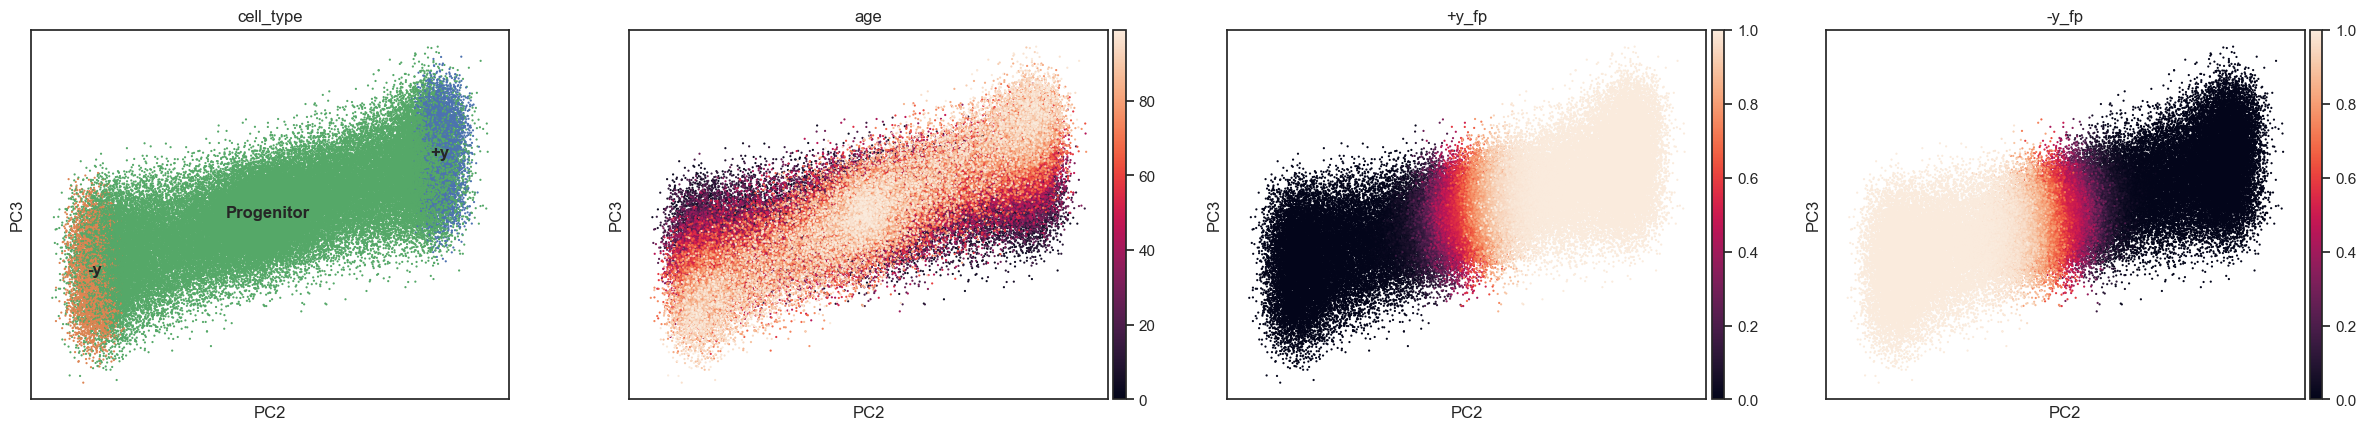

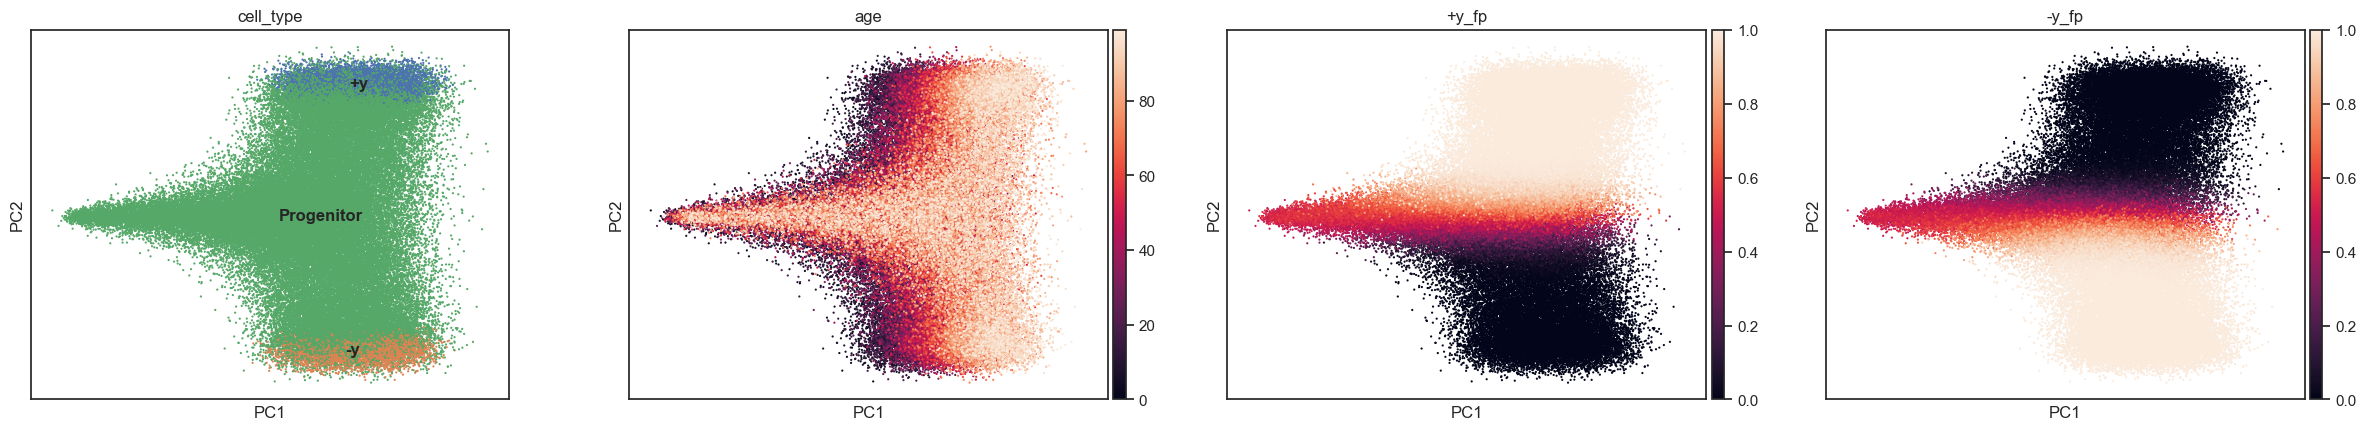

In [3]:
sim_adata.obs['+y_fp'] = sim_adata.obsm['cell_type_fp'][:,0]
sim_adata.obs['-y_fp'] = sim_adata.obsm['cell_type_fp'][:,1]
sc.pl.pca(sim_adata, color=['cell_type', 'age', '+y_fp', '-y_fp'], components=['2,3'], size=10, legend_loc='on data')
sc.pl.pca(sim_adata, color=['cell_type', 'age', '+y_fp', '-y_fp'], components=['1,2'], size=10, legend_loc='on data')

In [4]:
# set time points for time coureses
ages = np.asarray(sim_adata.obs['age'].unique())
age_span = ages.max() - ages.min()
T_list = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
first_time = 2
final_time = 99
time_lists = {}
for T in T_list:
    theo_times = np.linspace(first_time, final_time, T, dtype=int)
    time_lists[T] = theo_times

# global parameters

key = 42 # seed for random number generator
n = 10 # number of cells per time point
T = 25
chosen_times = time_lists[T] 

# trajectory sampling parameters
sim_dt = dt =  0.01
num_step = int(2/dt) # 2 days
num_traj = sim_adata.uns['traj_data']['0.0'].shape[0] # 500 

adata_keys  = {'time_key': 'age', # key in adata.obs for age annotation
               'cell_type_key': 'cell_type', # key in adata.obs for cell type annotation
               'growth_rate_key': 'growth_rate', # key in adata.obs for cell growth rates
               'embed_key': 'X_pca'}

# gStatOT

Cost scaled by mean
Completed 10000 total iterations, current error: 3.5599e-04
Completed 20000 total iterations, current error: 6.7904e-04
Completed 30000 total iterations, current error: 1.2933e-04
Completed 40000 total iterations, current error: 1.2560e-04
Completed 50000 total iterations, current error: 4.8183e-05
Ran 50000 iterations in 0.76 minutes.
Final objective value: -1.6528e+00
grad norm: 1.825e-04
max constraint error: 4.818e-05
ended in failed line search: False


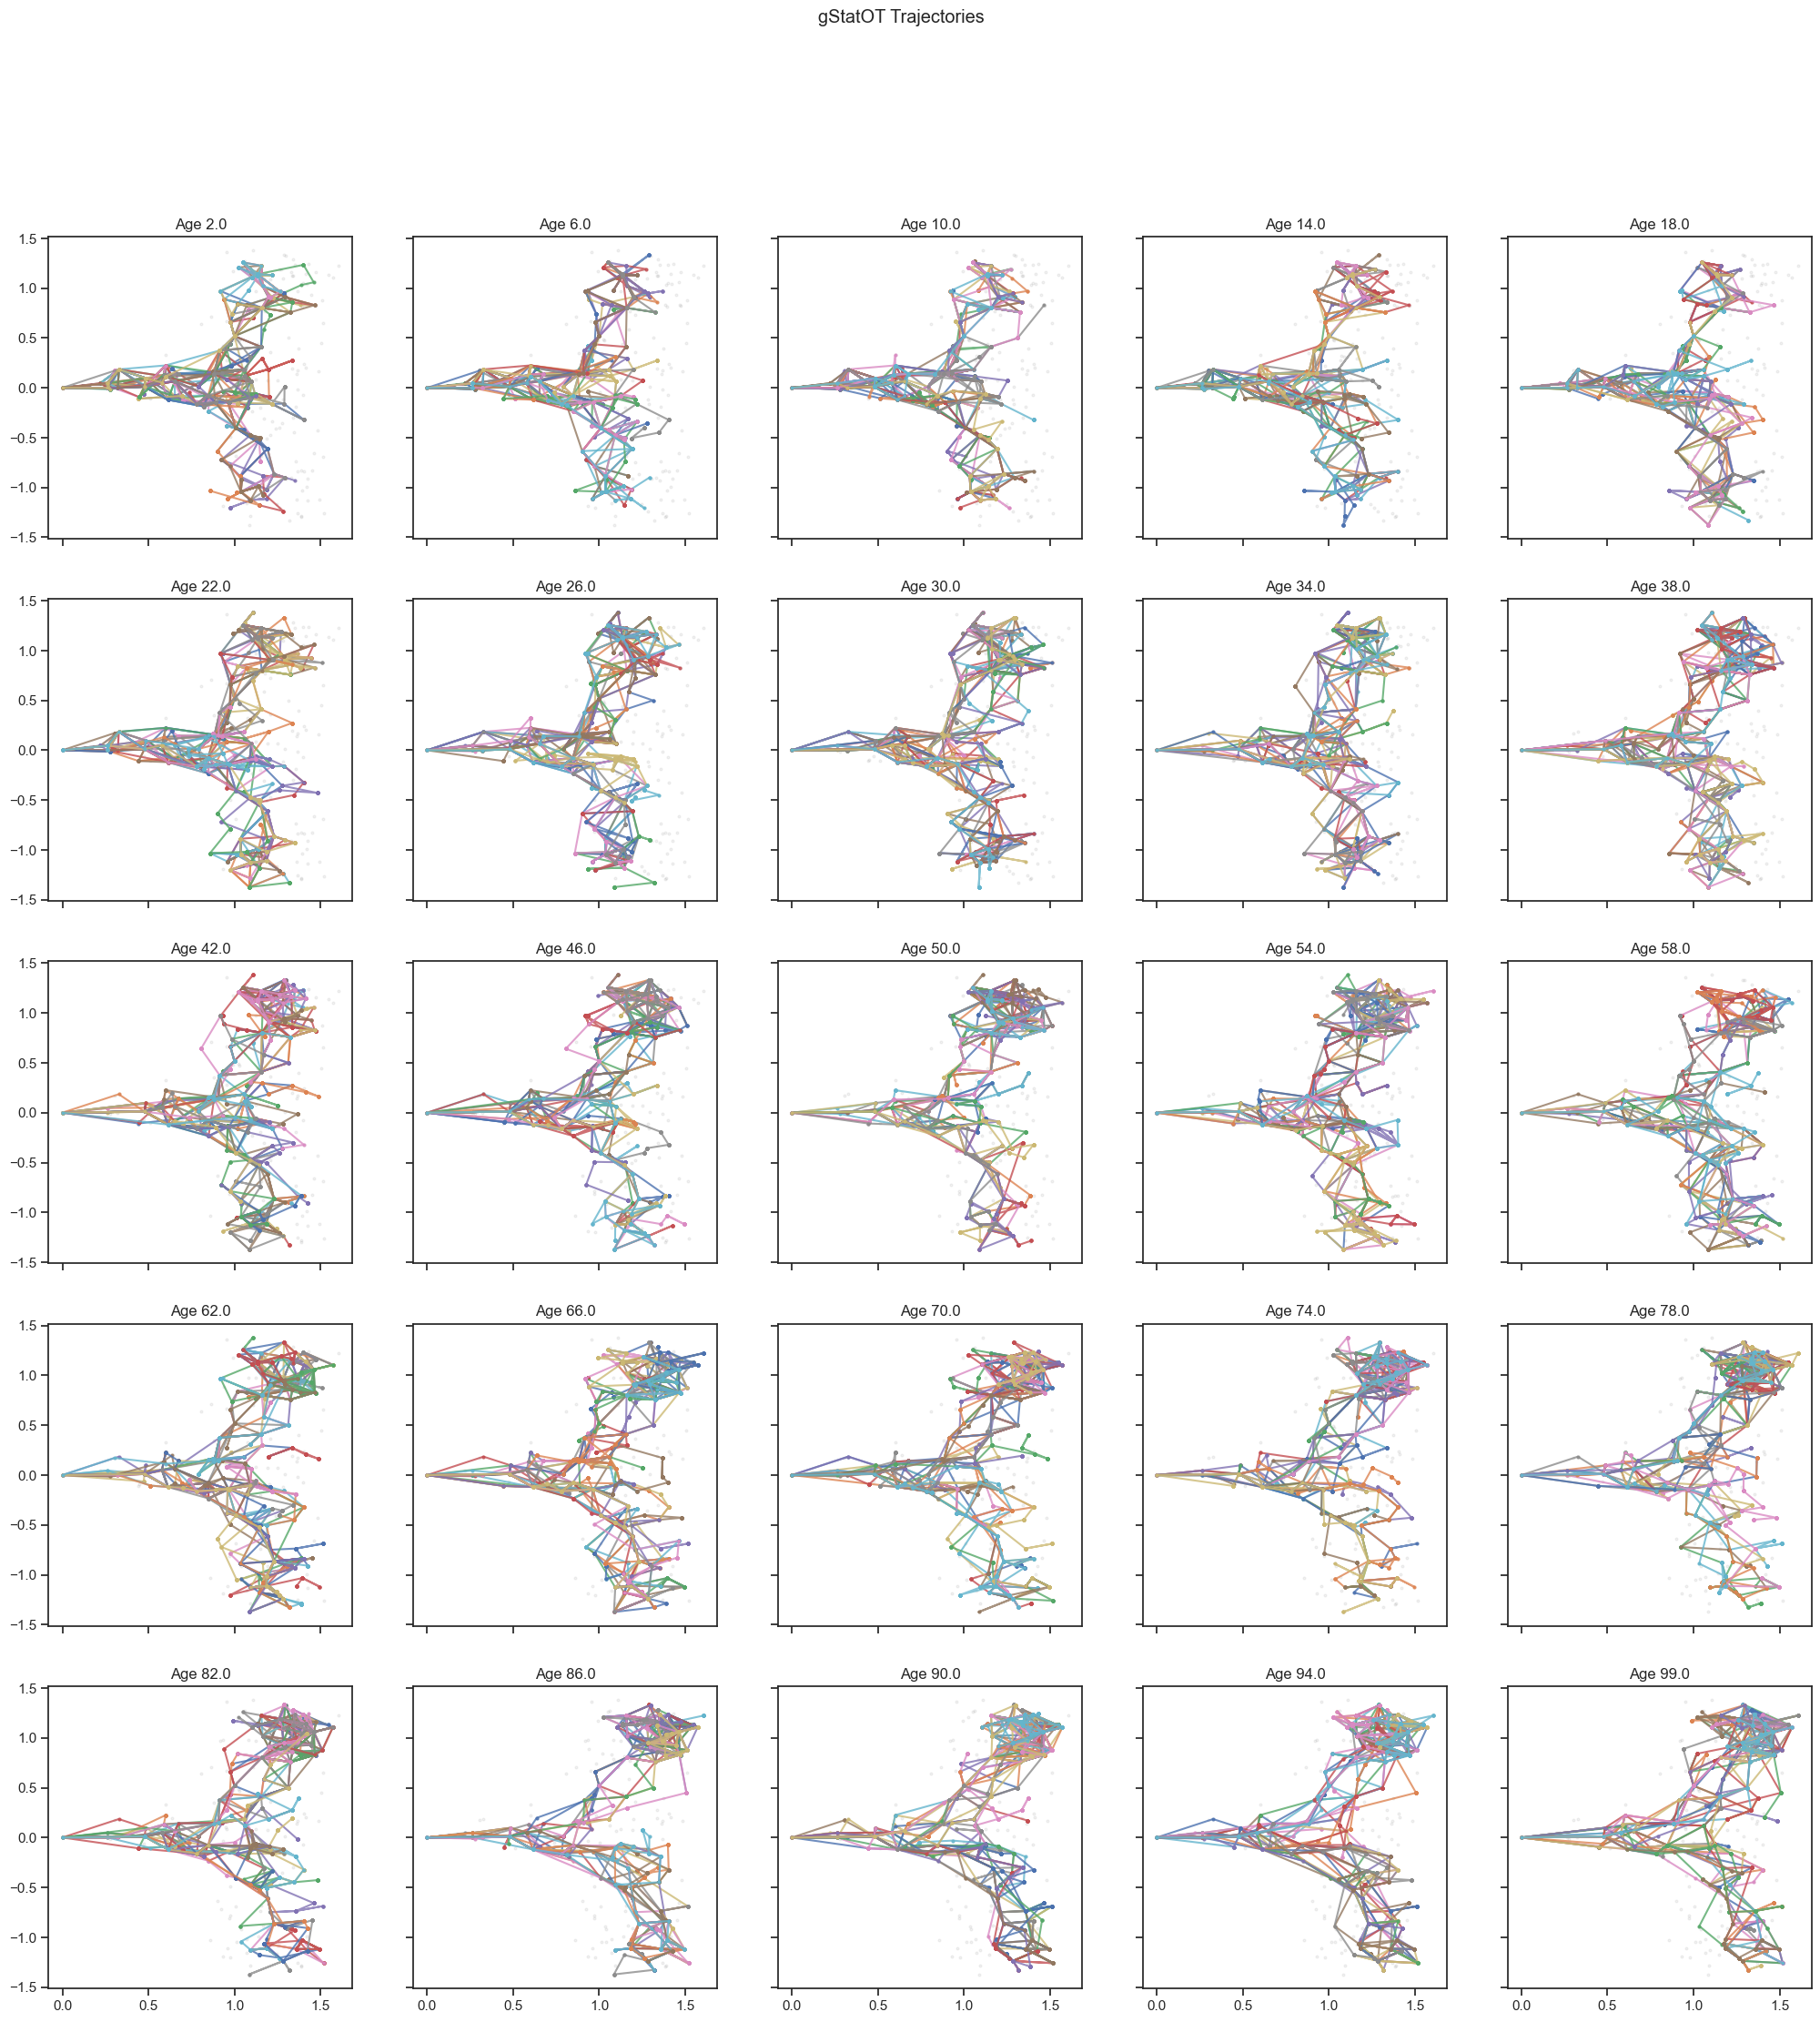

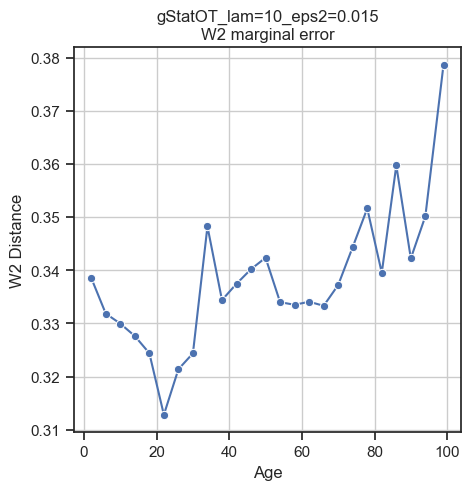

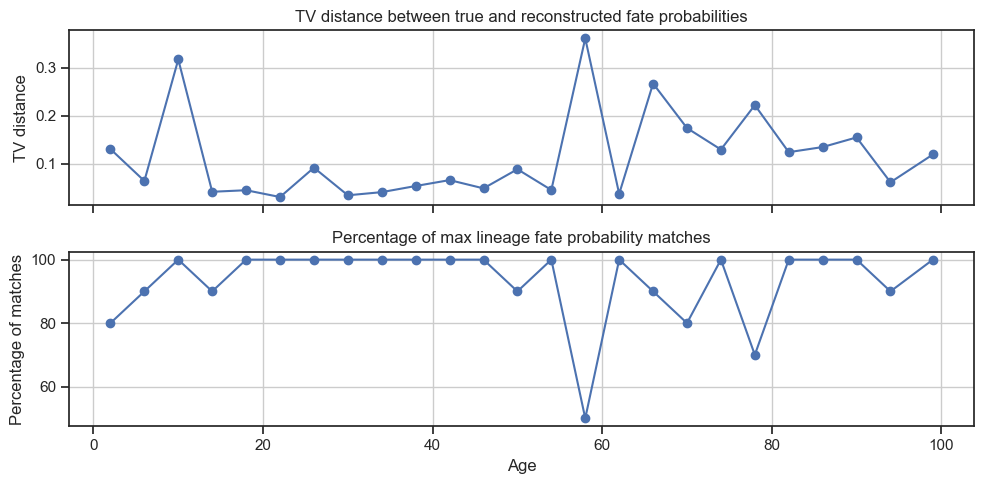

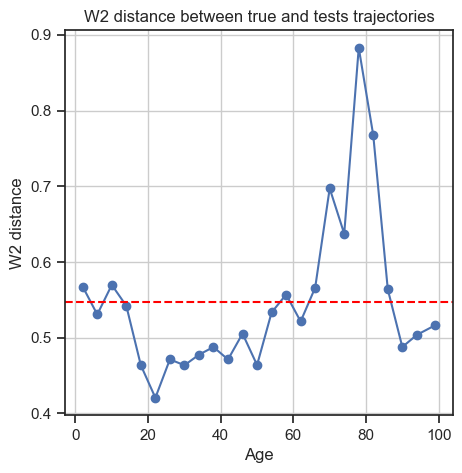

In [5]:
downsampled_adata, _ = utils.downsample_adata_by_age(sim_adata, n=n, time_key='age', PRNG_KEY=key, chosen_times=chosen_times)
gSOT = gStatOT(adata=downsampled_adata, adata_keys=adata_keys, dt=dt)

model_params = {'lam': 10,
                'w' : 1.0,
                'epsilon2': 0.015,
                'epsilon1': 0.005, 
                'epsilon3': 0.005,
                'r': 0.1} # scaling on entropic OT loss

gSOT.fit(model_params=model_params, max_iter=100_000, verbose=True, constraint_tol=1e-4, solver_kwargs={'inner_iter':10_000,
                                                                                                        'num_restarts': 10})
gSOT.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], all_labels=np.unique(sim_adata.obs[adata_keys['cell_type_key']]))
gSOT.get_trajectories(num_step=num_step, num_traj=num_traj, plot_traj=True)

method_str = 'gStatOT_' + 'lam=' + str(model_params['lam']) + '_' + 'eps2=' + str(model_params['epsilon2'])

metric_tests = metrics.Metric_Evaluator(method=method_str,
                                        test_adata=downsampled_adata,
                                        true_adata=sim_adata,
                                        time_key=adata_keys['time_key'],
                                        embed_key=adata_keys['embed_key'],
                                        exp_dir=None)

metric_tests.w2_marginal_error()
metric_tests.fp_tv_error(label_key='cell_type')
metric_tests.w2_trajectory_error(test_dt=dt, true_dt=sim_dt)

### Gene fitting

100%|██████████| 25/25 [00:00<00:00, 29.21it/s]


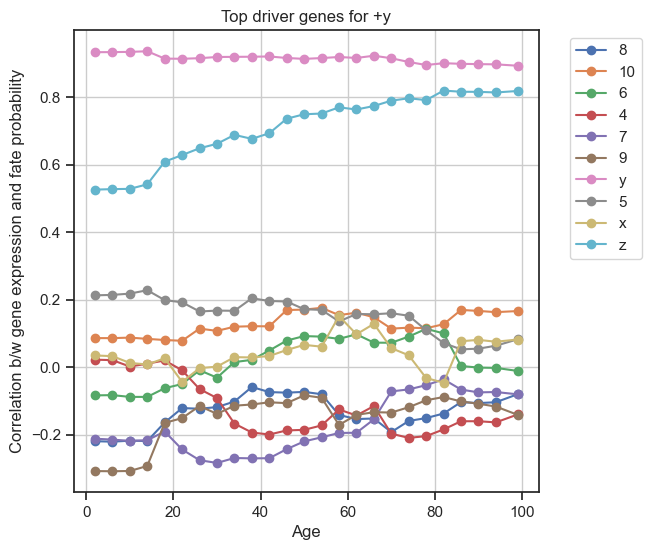

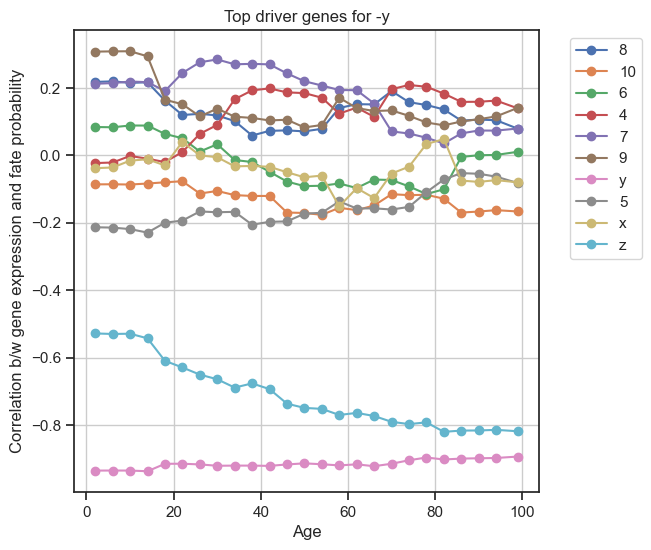

In [6]:
dg_identifier = driver_genes.gene_selection(adata=downsampled_adata,
                                 adata_keys=adata_keys)

fate_names = np.unique(downsampled_adata.obs[adata_keys['cell_type_key']])
dg_identifier.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
dg_identifier.plot_top_corr_over_age(fate_names=['+y', '-y'], n_top_genes=10)

# StatOT

Cost scaled by  mean
Time 2.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 6.0, ran 5000 iterations, inf norm error: 3.7253e-08
Time 10.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 14.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 18.0, ran 5000 iterations, inf norm error: 2.9802e-08
Time 22.0, ran 5000 iterations, inf norm error: 1.0431e-07
Time 26.0, ran 5000 iterations, inf norm error: 3.7253e-08
Time 30.0, ran 5000 iterations, inf norm error: 3.7253e-08
Time 34.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 38.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 42.0, ran 5000 iterations, inf norm error: 2.2352e-08
Time 46.0, ran 5000 iterations, inf norm error: 3.7253e-08
Time 50.0, ran 5000 iterations, inf norm error: 4.4703e-08
Time 54.0, ran 5000 iterations, inf norm error: 4.4703e-08
Time 58.0, ran 5000 iterations, inf norm error: 3.7253e-08
Time 62.0, ran 5000 iterations, inf norm error: 5.2154e-08
Time 66.0, ran 5000 iterations, inf n

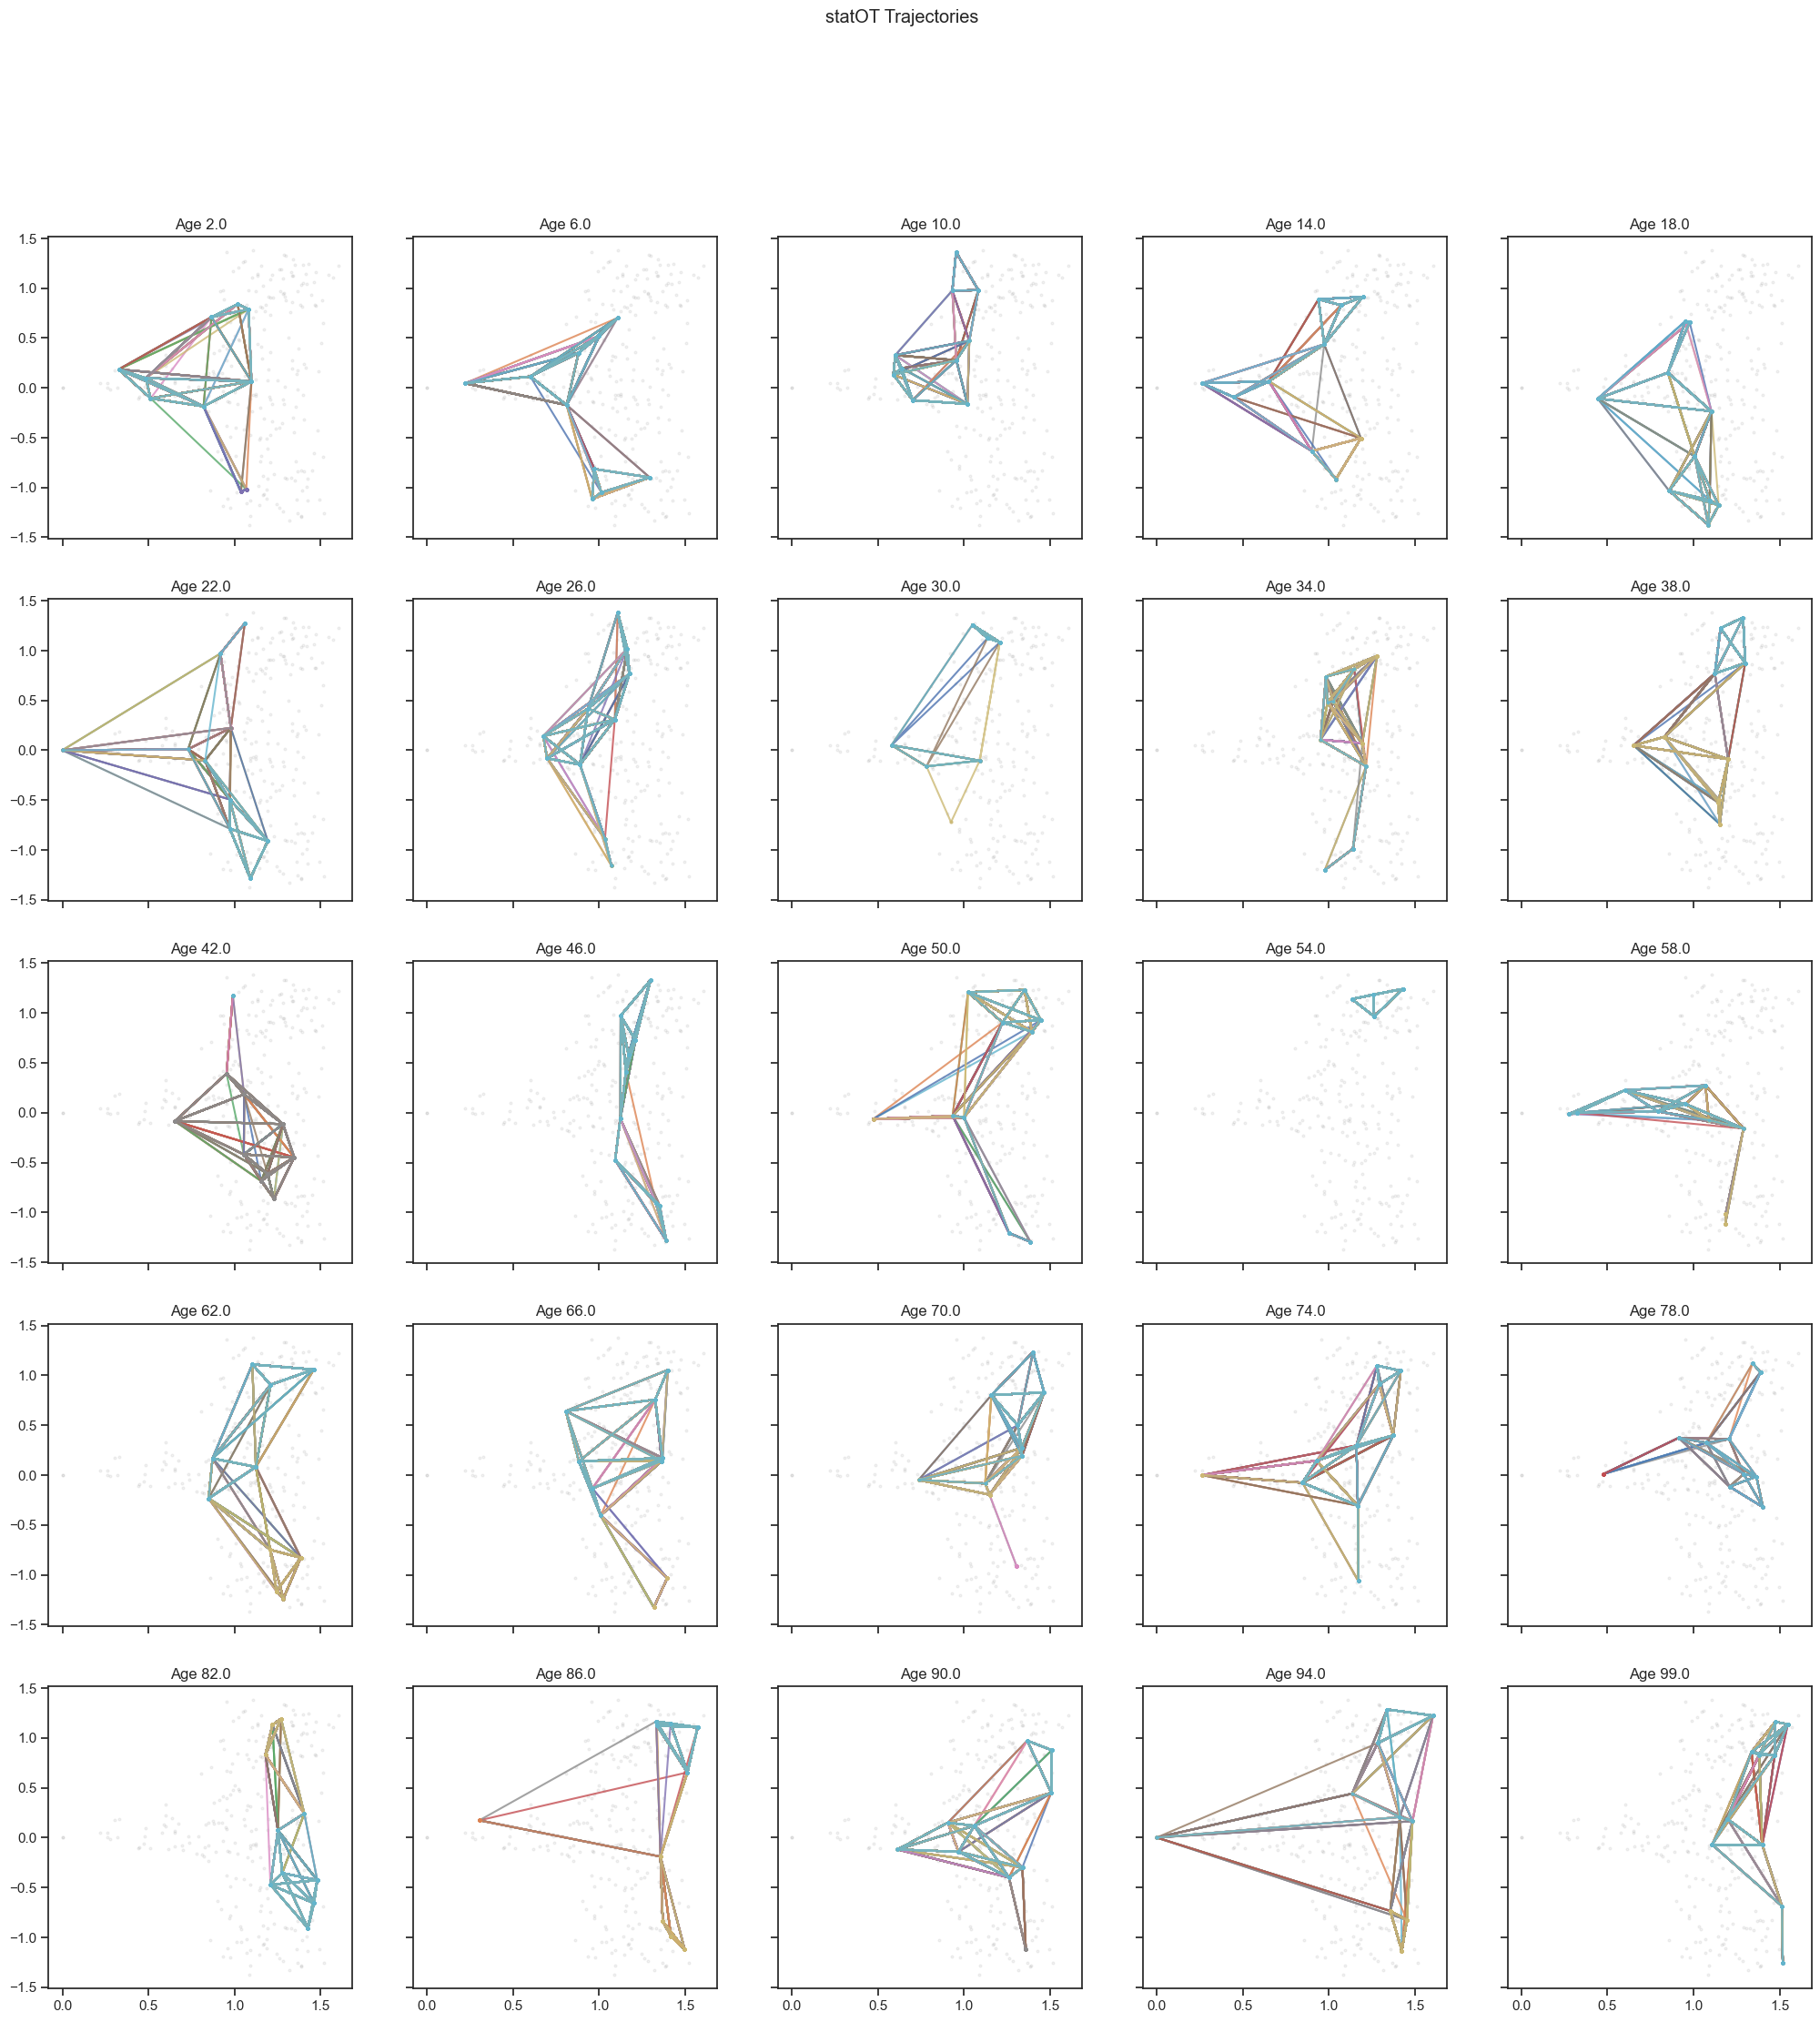

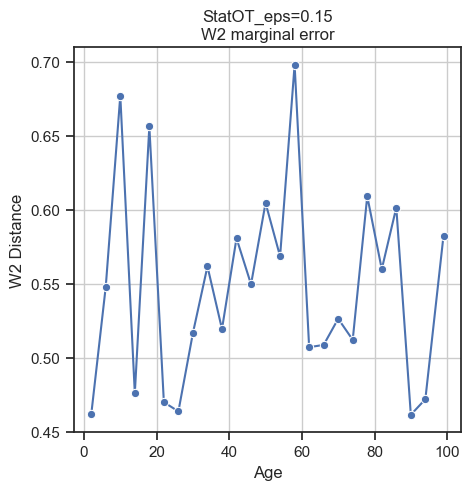

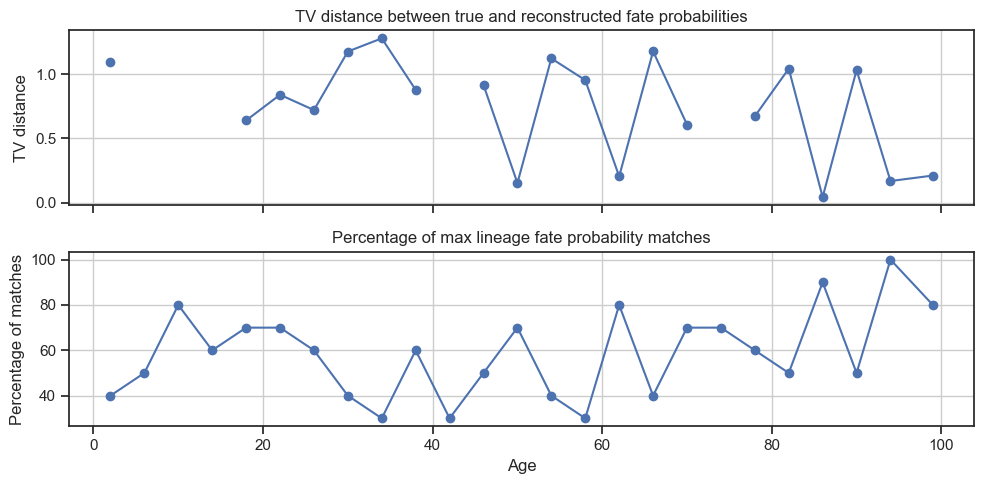

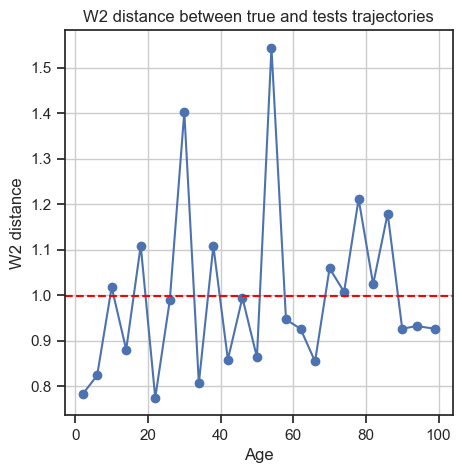

In [7]:
sot_down_sampled_adata, _ = utils.downsample_adata_by_age(sim_adata, n=n, time_key='age', PRNG_KEY=key, chosen_times=chosen_times)

SOT = StatOT(adata=sot_down_sampled_adata, adata_keys=adata_keys, dt=dt, dtype=jnp.float32)

SOT_params = {'epsilon': 0.15,
              'lse': True,
              'cost_scaling': 'mean'}

SOT.fit(model_params=SOT_params, max_iter=15_000, verbose=True)

SOT.get_lin_fate_probs(label_key=adata_keys['cell_type_key'], all_labels=np.unique(sim_adata.obs[adata_keys['cell_type_key']]))
SOT.get_trajectories(num_step=num_step, num_traj=num_traj, plot_traj=True)
method_str = 'StatOT_' + 'eps=' + str(SOT_params['epsilon']) 

sot_metric_tests = metrics.Metric_Evaluator(method=method_str,
                                        test_adata=sot_down_sampled_adata,
                                        true_adata=sim_adata,
                                        time_key='age',
                                        embed_key='X_pca',
                                        exp_dir=None,
                                        full_supp=False)

sot_metric_tests.w2_marginal_error()
sot_metric_tests.fp_tv_error(label_key=adata_keys['cell_type_key'])

sot_metric_tests.w2_trajectory_error(test_dt=dt, true_dt=sim_dt)


### Gene fitting

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 38.64it/s]


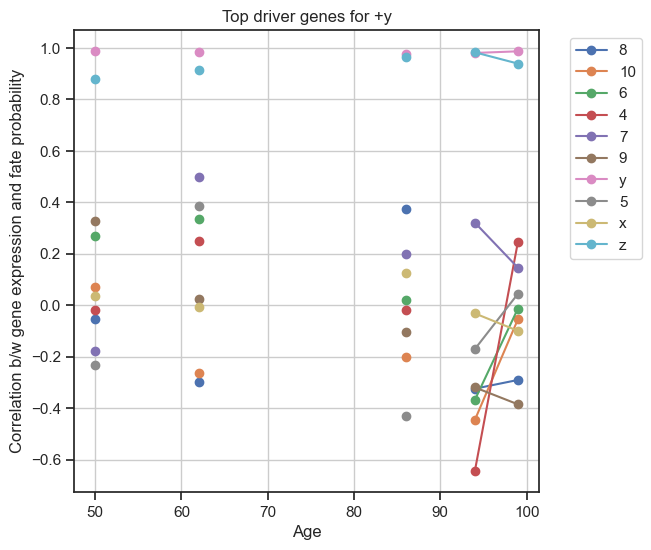

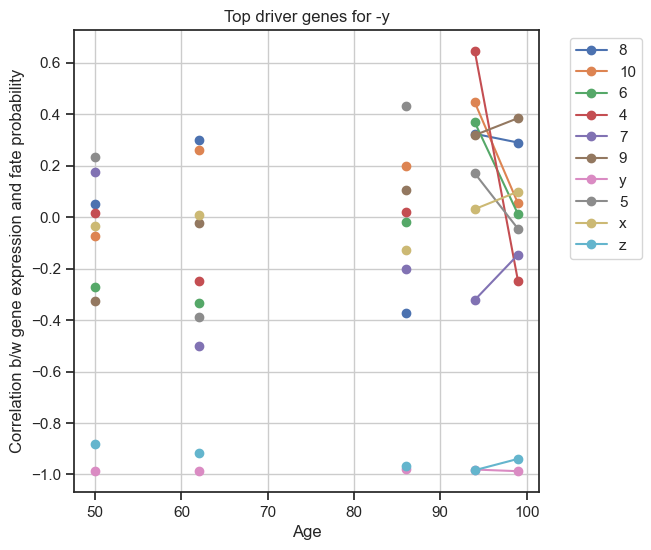

In [8]:

sot_dg_identifier = driver_genes.gene_selection(adata=sot_down_sampled_adata,
                                 adata_keys=adata_keys, full_supp=False)
fate_names = np.unique(sim_adata.obs[adata_keys['cell_type_key']])
sot_dg_identifier.get_fp_expression_corr(label_key=adata_keys['cell_type_key'], fate_names=fate_names)
sot_dg_identifier.plot_top_corr_over_age(n_top_genes=10, fate_names=['+y', '-y'], rank_by_abs_corr=True)

# Compare

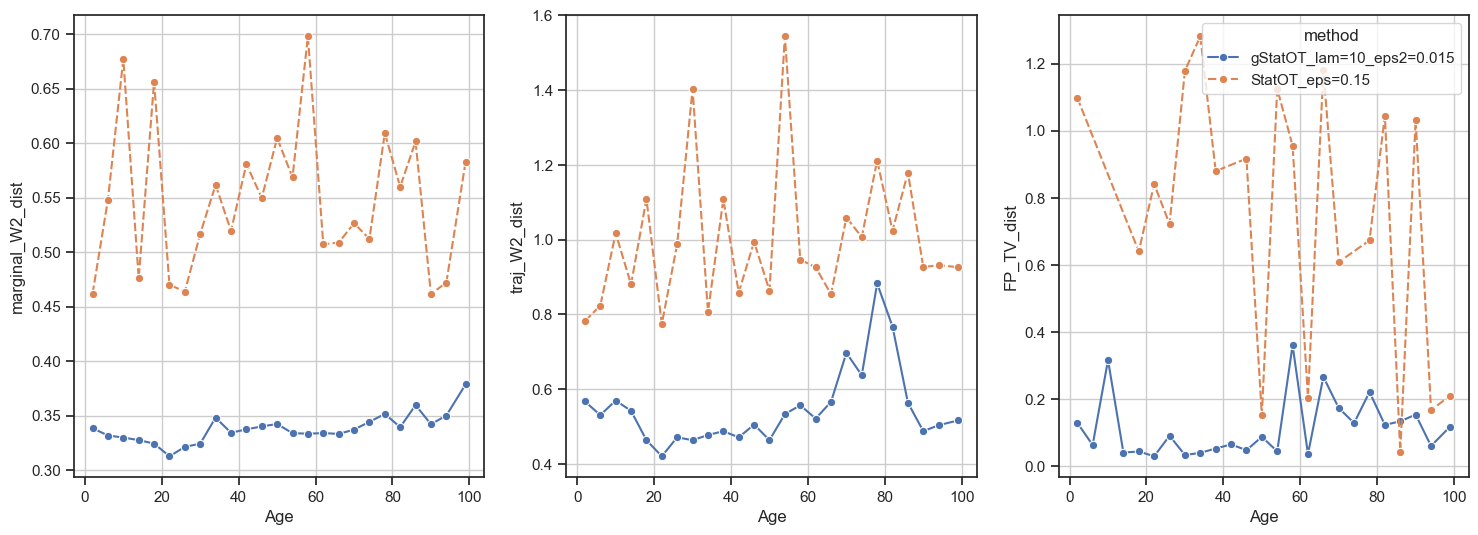

In [9]:
df_all = pd.concat([metric_tests.results_df, sot_metric_tests.results_df]).reset_index(drop=True)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(data=df_all, x='Age', y='marginal_W2_dist', hue='method', style='method', marker='o', ax=axs[0])
axs[0].legend().remove()
axs[0].grid()
sns.lineplot(data=df_all, x='Age', y='traj_W2_dist', hue='method', style='method', marker='o', ax=axs[1])
axs[1].legend().remove()
axs[1].grid()
sns.lineplot(data=df_all, x='Age', y='FP_TV_dist', hue='method', style='method', marker='o', ax=axs[2])
axs[2].grid()